# In this notebook I will perform some Datawrangling using Python API of Spark

**The data is obtained from MovieLens can be found here https://grouplens.org/datasets/movielens/25m/**

*Import findspark* to run spark on local mode in windows

In [2]:
import findspark

In [3]:
findspark.init()

Import Spark Session from Pyspark.sql to create well a Spark Session, I will also be enabling hive support to read and write tables to hive

In [4]:
from pyspark.sql import SparkSession

In [5]:
spark = SparkSession.builder.enableHiveSupport().appName("Movie lens data wrangling").getOrCreate()

Now that we have the spark session up and running we can read the files, the files are in csv format (comma separated) where comma are escaped in double quotes. The files are encoded in UTF-8.

In [6]:
! dir movielens\ml-25m

 El volumen de la unidad C es Windows
 El n£mero de serie del volumen es: 55D7-D790

 Directorio de C:\Users\Usuario\Desktop\Pyspark-demo\Data wrangling\movielens\ml-25m

12/10/2020  12:23    <DIR>          .
12/10/2020  12:23    <DIR>          ..
12/10/2020  12:23       435.164.157 genome-scores.csv
12/10/2020  12:23            18.103 genome-tags.csv
12/10/2020  12:23         1.368.578 links.csv
12/10/2020  12:23         3.038.099 movies.csv
12/10/2020  12:23       678.260.987 ratings.csv
12/10/2020  12:23            10.460 README.txt
12/10/2020  12:23        38.810.332 tags.csv
               7 archivos  1.156.670.716 bytes
               2 dirs  783.430.131.712 bytes libres


**We can see that we have 6 csv files at our disposal**

### Section 1 - ratings and movies

which movies have the best average ratings and how many people rated them?

I am going to start by reading ratings.csv 

In [7]:
ratings = spark.read.format("csv").option("delimiter", ","
                                         ).option("ESCAPE quote", '"'
                                                 ). option("header",True
                                                          ).option("encoding", "UTF-8").load("movielens/ml-25m/ratings.csv"
                                                                                            ).coalesce(4)

I am going to partition the file into 4 chunks to improve performance (pay attention the last chained command **coalesce**), but when you are working on a cluster partition the file into number of nodes that you have in your cluster

Lets take a look at its first few rows

In [8]:
ratings.rdd.getNumPartitions()

4

In [9]:
ratings.show()

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|    296|   5.0|1147880044|
|     1|    306|   3.5|1147868817|
|     1|    307|   5.0|1147868828|
|     1|    665|   5.0|1147878820|
|     1|    899|   3.5|1147868510|
|     1|   1088|   4.0|1147868495|
|     1|   1175|   3.5|1147868826|
|     1|   1217|   3.5|1147878326|
|     1|   1237|   5.0|1147868839|
|     1|   1250|   4.0|1147868414|
|     1|   1260|   3.5|1147877857|
|     1|   1653|   4.0|1147868097|
|     1|   2011|   2.5|1147868079|
|     1|   2012|   2.5|1147868068|
|     1|   2068|   2.5|1147869044|
|     1|   2161|   3.5|1147868609|
|     1|   2351|   4.5|1147877957|
|     1|   2573|   4.0|1147878923|
|     1|   2632|   5.0|1147878248|
|     1|   2692|   5.0|1147869100|
+------+-------+------+----------+
only showing top 20 rows



We can see that the time stamp are unix (number of seconds since 1 january 1970) 

**I am going to convert timestamp to human readable timestamp**

Importing necessary modules

In [10]:
from pyspark.sql import functions as f
from pyspark.sql import types as t


Looking at datatypes of each column

In [11]:
ratings.dtypes

[('userId', 'string'),
 ('movieId', 'string'),
 ('rating', 'string'),
 ('timestamp', 'string')]

In [12]:
ratings = ratings.withColumn('timestamp',f.from_unixtime(ratings.timestamp.cast(dataType=t.LongType())))

The rating column is of string datatype, I am going to convert it to a Float

In [13]:
ratings = ratings.withColumn('rating',ratings.rating.cast(dataType=t.FloatType()))

In [14]:
ratings.show()

+------+-------+------+-------------------+
|userId|movieId|rating|          timestamp|
+------+-------+------+-------------------+
|     1|    296|   5.0|2006-05-17 17:34:04|
|     1|    306|   3.5|2006-05-17 14:26:57|
|     1|    307|   5.0|2006-05-17 14:27:08|
|     1|    665|   5.0|2006-05-17 17:13:40|
|     1|    899|   3.5|2006-05-17 14:21:50|
|     1|   1088|   4.0|2006-05-17 14:21:35|
|     1|   1175|   3.5|2006-05-17 14:27:06|
|     1|   1217|   3.5|2006-05-17 17:05:26|
|     1|   1237|   5.0|2006-05-17 14:27:19|
|     1|   1250|   4.0|2006-05-17 14:20:14|
|     1|   1260|   3.5|2006-05-17 16:57:37|
|     1|   1653|   4.0|2006-05-17 14:14:57|
|     1|   2011|   2.5|2006-05-17 14:14:39|
|     1|   2012|   2.5|2006-05-17 14:14:28|
|     1|   2068|   2.5|2006-05-17 14:30:44|
|     1|   2161|   3.5|2006-05-17 14:23:29|
|     1|   2351|   4.5|2006-05-17 16:59:17|
|     1|   2573|   4.0|2006-05-17 17:15:23|
|     1|   2632|   5.0|2006-05-17 17:04:08|
|     1|   2692|   5.0|2006-05-1

Now that we have the timestamp in human readable format, let's find out which movies have the highest average rating as well how many people rated them

Since I will be using the movieId column to group by, I will repartition the dataframe by MovieId to improve performace on joining with the dataframe I will be reading containing information of each movies

In [15]:
ratings = ratings.repartition("movieId").coalesce(4)

In [16]:
ratings.persist()

DataFrame[userId: string, movieId: string, rating: float, timestamp: string]

**I will now be reading movies.csv which contains information of each movie**

In [17]:
movies = spark.read.format("csv").option("delimiter", ","
                                         ).option("ESCAPE quote", '"'
                                                 ). option("header",True
                                                          ).option("encoding", "UTF-8").load("movielens/ml-25m/movies.csv"
                                                                                            )

In [18]:
movies.show()

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
|      6|         Heat (1995)|Action|Crime|Thri...|
|      7|      Sabrina (1995)|      Comedy|Romance|
|      8| Tom and Huck (1995)|  Adventure|Children|
|      9| Sudden Death (1995)|              Action|
|     10|    GoldenEye (1995)|Action|Adventure|...|
|     11|American Presiden...|Comedy|Drama|Romance|
|     12|Dracula: Dead and...|       Comedy|Horror|
|     13|        Balto (1995)|Adventure|Animati...|
|     14|        Nixon (1995)|               Drama|
|     15|Cutthroat Island ...|Action|Adventure|...|
|     16|       Casino (1995)|         Crime|Drama|
|     17|Sen

Repartitioning movies dataframe also on movieId

In [19]:
movies = movies.repartition("movieId").coalesce(4)

#### I am going to calculate average and count of ratings by movieId then I will filter and keep only movies with rating 3.5 or more.

#### Later I will join ratings with movies to find out names of the movies that got the highest rating. 

In [20]:
aggregated_ratings = ratings.groupBy("movieId").agg(
    f.avg("rating").alias("average_rating"),f.count("rating").alias("count_rating")).where(
    f.col("average_rating")>=3.5).orderBy(
    f.desc("average_rating"),f.desc("count_rating"))

In [21]:
aggregated_with_names = aggregated_ratings.join(movies, (movies.movieId==ratings.movieId),"inner").drop(movies["movieId"])

aggregated_with_names.show()

+-------+--------------+------------+--------------------+--------------------+
|movieId|average_rating|count_rating|               title|              genres|
+-------+--------------+------------+--------------------+--------------------+
| 165787|           5.0|           3|Lonesome Dove Chu...|             Western|
| 179731|           5.0|           3|Sound of Christma...|               Drama|
| 148298|           5.0|           3|       Awaken (2013)|Drama|Romance|Sci-Fi|
| 118268|           5.0|           3|Borrowed Time (2012)|               Drama|
| 148114|           5.0|           2|The Ties That Bin...|  (no genres listed)|
| 208477|           5.0|           2|       Kaithi (2019)|     Action|Thriller|
| 178147|           5.0|           2|Beatles Stories (...|         Documentary|
| 195641|           5.0|           2|Final Recourse (2...|      Drama|Thriller|
| 179589|           5.0|           2|  Windstorm 2 (2015)|Adventure|Childre...|
| 179559|           5.0|           2|The

Movies that have been rated really high were actually not rated by a lot of people

great! Maybe this table could be really important for a website that sells movie tickets, as we have seen the spark actions take a while to compute and it is highly recommended to save tables (for example as a hive table) that might be needed very often. such tables can be consulted via spark sessions as well.

**Note: before creating a temporary view from a dataframe, cache it to get the best performace**

In [22]:

aggregated_with_names.persist()

aggregated_with_names.createOrReplaceTempView("movie_ratings")

first I registered it as a temporary view and I will dump it into a hive table

spark.sql(''' CREATE TABLE IF NOT EXISTS movie_ratings_hive USING parquet PARTITIONED BY (movieId)
        AS select * from movie_ratings''')

Coming back, let us see which movies were rated by a large number of people 

In [23]:
spark.sql("select * from movie_ratings order by count_rating desc").show()

+-------+------------------+------------+--------------------+--------------------+
|movieId|    average_rating|count_rating|               title|              genres|
+-------+------------------+------------+--------------------+--------------------+
|    356| 4.048011436845787|       81491| Forrest Gump (1994)|Comedy|Drama|Roma...|
|    318| 4.413576004516335|       81482|Shawshank Redempt...|         Crime|Drama|
|    296| 4.188912039361382|       79672| Pulp Fiction (1994)|Comedy|Crime|Dram...|
|    593| 4.151341616415071|       74127|Silence of the La...|Crime|Horror|Thri...|
|   2571| 4.154099127610975|       72674|  Matrix, The (1999)|Action|Sci-Fi|Thr...|
|    260| 4.120188599618726|       68717|Star Wars: Episod...|Action|Adventure|...|
|    480|3.6791749812920926|       64144|Jurassic Park (1993)|Action|Adventure|...|
|    527| 4.247579083279535|       60411|Schindler's List ...|           Drama|War|
|    110| 4.002272573668559|       59184|   Braveheart (1995)|    Action|Dra

Let us look at the movies which were watched by an insane number of people (20000 in this case) and was really well received (more than 4 stars). (That is what a **Blockbuster** means, right?)

**ordered by count of ratings**

In [24]:
spark.sql("select * from movie_ratings where average_rating > 4.0 and count_rating>20000 order by count_rating desc").show()

+-------+------------------+------------+--------------------+--------------------+
|movieId|    average_rating|count_rating|               title|              genres|
+-------+------------------+------------+--------------------+--------------------+
|    356| 4.048011436845787|       81491| Forrest Gump (1994)|Comedy|Drama|Roma...|
|    318| 4.413576004516335|       81482|Shawshank Redempt...|         Crime|Drama|
|    296| 4.188912039361382|       79672| Pulp Fiction (1994)|Comedy|Crime|Dram...|
|    593| 4.151341616415071|       74127|Silence of the La...|Crime|Horror|Thri...|
|   2571| 4.154099127610975|       72674|  Matrix, The (1999)|Action|Sci-Fi|Thr...|
|    260| 4.120188599618726|       68717|Star Wars: Episod...|Action|Adventure|...|
|    527| 4.247579083279535|       60411|Schindler's List ...|           Drama|War|
|    110| 4.002272573668559|       59184|   Braveheart (1995)|    Action|Drama|War|
|   2959| 4.228310618821568|       58773|   Fight Club (1999)|Action|Crime|D

Forrest Gump was rated by most people

**ordered by average rating**

In [25]:
spark.sql("select * from movie_ratings where average_rating > 4.0 and count_rating>20000 order by average_rating desc").show()

+-------+------------------+------------+--------------------+--------------------+
|movieId|    average_rating|count_rating|               title|              genres|
+-------+------------------+------------+--------------------+--------------------+
|    318| 4.413576004516335|       81482|Shawshank Redempt...|         Crime|Drama|
|    858| 4.324336165187245|       52498|Godfather, The (1...|         Crime|Drama|
|     50| 4.284353213163313|       55366|Usual Suspects, T...|Crime|Mystery|Thr...|
|   1221|4.2617585117585115|       34188|Godfather: Part I...|         Crime|Drama|
|    527| 4.247579083279535|       60411|Schindler's List ...|           Drama|War|
|    904| 4.237947624243627|       20162|  Rear Window (1954)|    Mystery|Thriller|
|   2959| 4.228310618821568|       58773|   Fight Club (1999)|Action|Crime|Dram...|
|   1193|4.2186616007543405|       36058|One Flew Over the...|               Drama|
|    750| 4.215804447106386|       26714|Dr. Strangelove o...|          Come

**Shawshank Redemption is the highest rated movie among all the popular movies we have in our dataset**

I suppose if you are really into movies then you surely must have heard of of all  of the titles listed above

Let me plot the 20 most rated movies that received an average rating of 4 or more using pandas and matplotlib


**converting the spark dataframe to pandas**

df.toPandas() can convert a spark dataframe to pandas dataframe

In [26]:
import plotly.express as px
import pandas as pd

In [27]:
most_viewed_highly_rated = spark.sql('''
                select * from movie_ratings where average_rating > 4.0 and 
                    count_rating>20000 order by count_rating desc limit 20''').toPandas()

In [28]:
fig = px.bar(most_viewed_highly_rated, x="count_rating", y="title", orientation='h', title='Total ratings of the Blockbusters')
fig.update_layout(
    autosize=False,
    width=1500,
    height=800,)
fig.write_image("most_viewed.jpeg")
#fig.show()

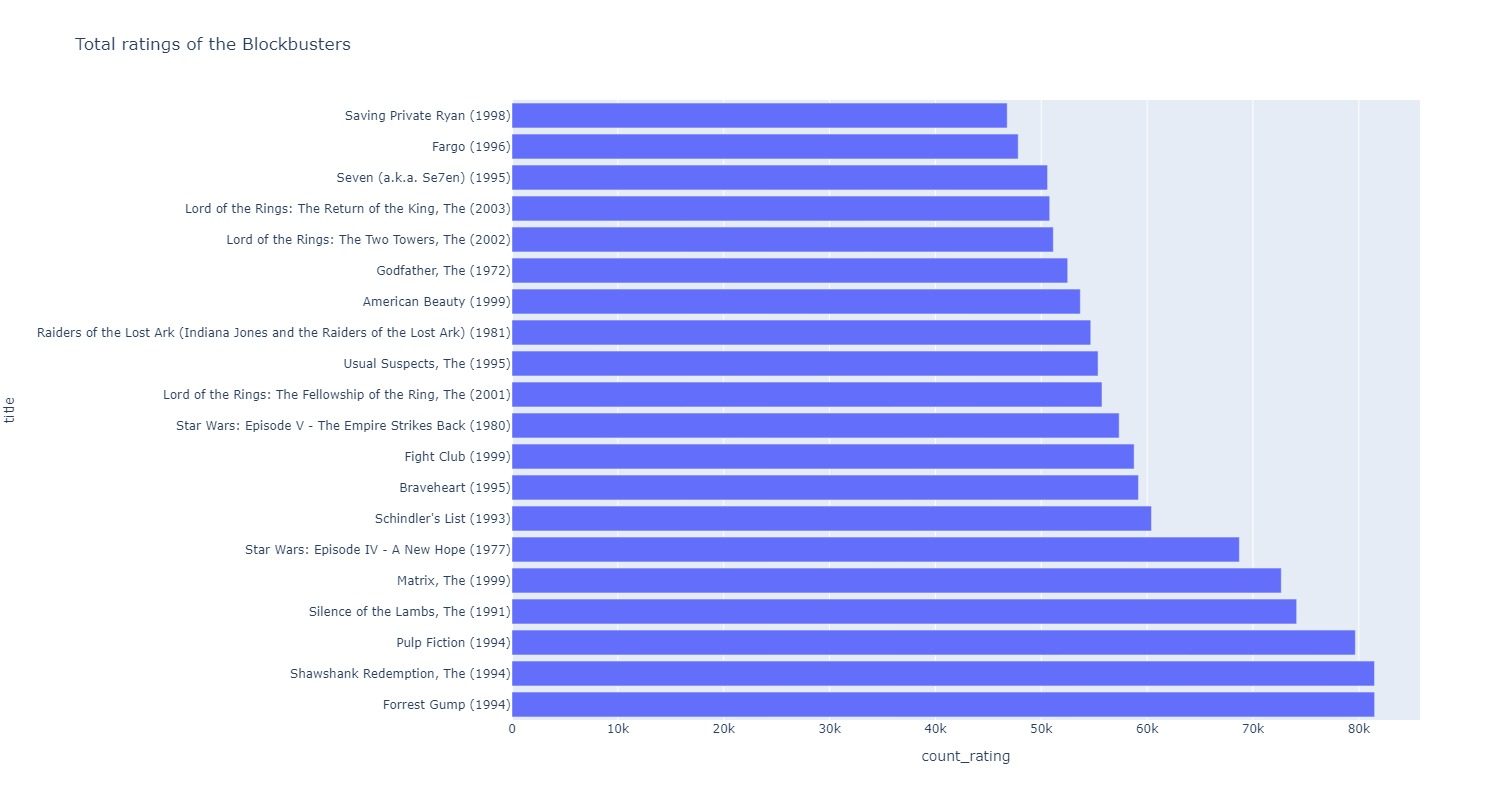

and now the 20 movies that have the best average rating (having atleast 20000 votes)

In [29]:
highly_rated_most_viewed = spark.sql('''
                select * from movie_ratings where average_rating > 4.0 and 
                    count_rating>20000 order by average_rating desc limit 20''').toPandas()

In [30]:
fig = px.bar(highly_rated_most_viewed, x="average_rating", y="title", orientation='h', title='20 Best rated of the Blockbusters')
fig.update_layout(
    autosize=False,
    width=1500,
    height=800,)
fig.write_image("best_rated.jpeg")
#fig.show()

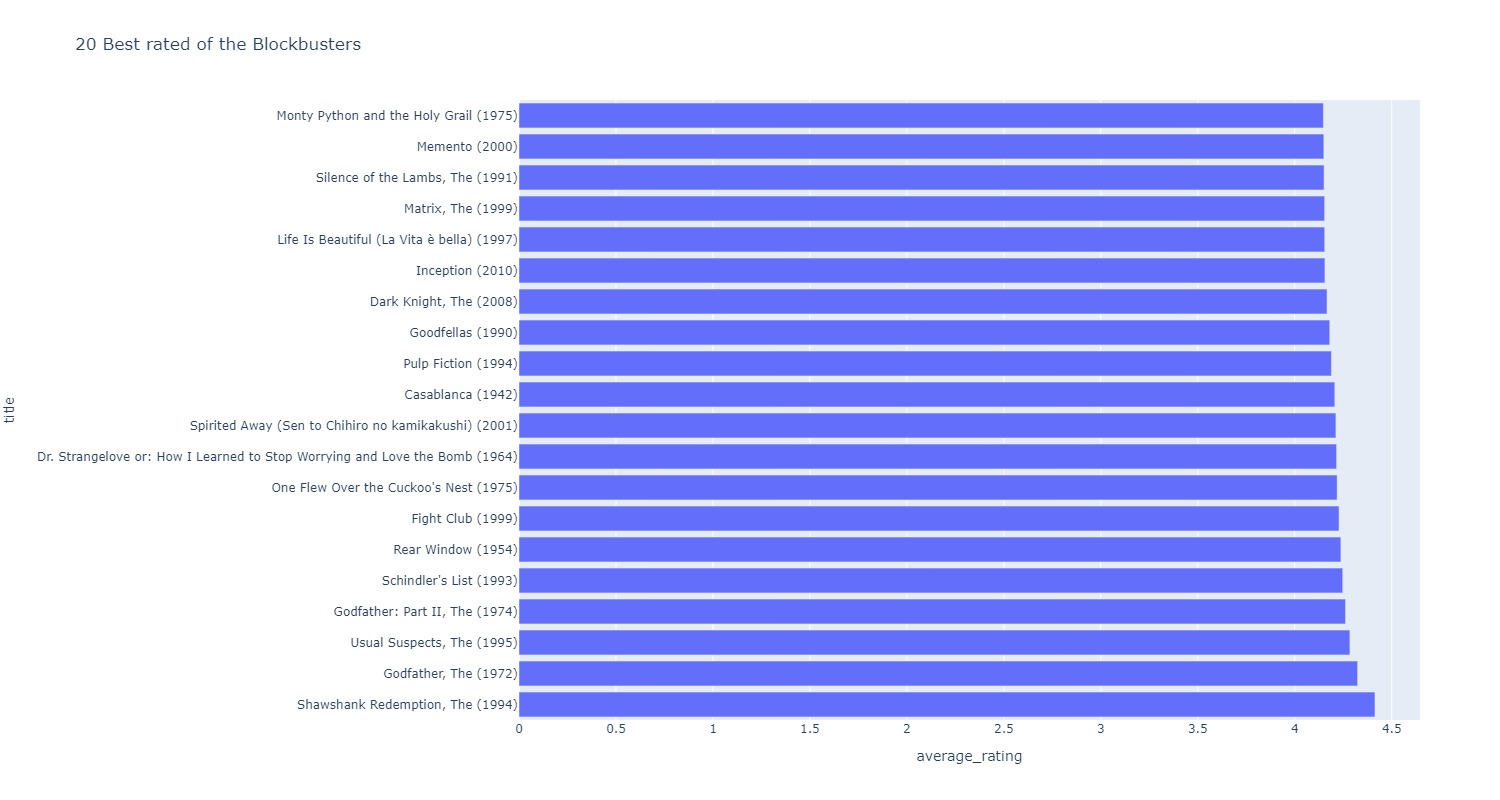

**Shawshank Redemption is the highest rated movie among all the popular movies we have in our dataset**

Great but what about the genre? which genre is the most popular? If you were to direct a cinema tommorow, which genre should you choose in order to get the most views?

but let me uncache the merged table now that we are done with that part of the analysis

In [31]:
aggregated_with_names.unpersist()

DataFrame[movieId: string, average_rating: double, count_rating: bigint, title: string, genres: string]

spark.catalog.clearCache()

## Section 2- Genres and ratings

**Work in progress**

In [32]:
spark.stop()